In [31]:
# Imports

import cv2
import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

from skimage import metrics

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [32]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

W_L = 0.5
W_R = 1.0
W_DR = 0.3
W_E = 2.0

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


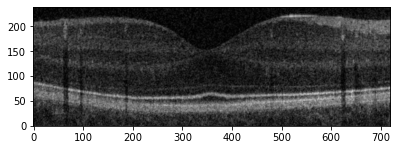

In [33]:

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [34]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)
    
    def environment_fitness(self, image, points=3):
        arr = []
        intermediates = self.intermediate_points(points)
        for point in intermediates:
            if (point[0] < 720 and point[1] < 240): 
                arr.append(255 - abs(self.colour * 255 - image[int(point[1]), int(point[0])]))
            else:
                arr.append(0)
        return np.average(arr)
    
    def distance(self, x, y):
        return np.sqrt((self.x - x)**2 + (self.y - y)**2)
    
    def invi_fitness(self):
        return W_L * self.approx_length() + W_R * self.r + W_DR * self.dr + W_E * self.environment_fitness(image)

In [35]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save, bbox_inches='tight')
        plt.show()

    def save(self, save=None):
        plt.axis('off')
        if save is not None:
            plt.savefig(save, bbox_inches='tight')
    
    def close(self):
        plt.close()

In [36]:
def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

In [37]:
def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

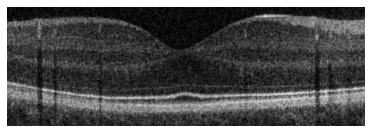

In [38]:
clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
# drawing.add_worms(clew)
# drawing.show("random.png")
drawing.save("original.png")
# drawing.show_image("random.png")

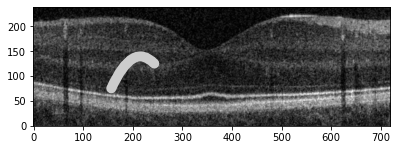

In [39]:
# Draw a single worm along with control points and some sample points
worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
# drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
# drawing.add_dots(worm.control_points(),color='orange')
# drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

In [40]:
rng.random()

0.09693293785826884

In [41]:
image1 = cv2.imread('random.png')
image2 = cv2.imread('original.png')
image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]), interpolation=cv2.INTER_AREA)

image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

cv2.imwrite("ig1.png", image1_gray)
cv2.imwrite("ig2.png", image2_gray)
metrics.structural_similarity(image1_gray, image2_gray, full=True)

(0.8308143758699681,
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

Representing each worm as Chromosome, placed randomly in the picture.


In [82]:
class Worms:
    
    def __init__(self, size, init_params=(40, 30, 1)):
        self.image = self.prep_image(IMAGE_DIR, IMAGE_NAME, MASK)
        self.imshape = self.image.shape
        self.init_params = init_params
        self.worms = self.initialise_clew(size)

    def prep_image (self, imdir, imname, mask):
        # print("Image name (shape) (intensity max, min, mean, std)\n")
        image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
        # print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
        # plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
        # plt.show()
        return image

    def initialise_clew (self, size):
        clew = []
        for i in range(size):
            clew.append(self.random_worm())
        return clew
        
    def random_worm(self):
        (radius_std, deviation_std, width_theta) = self.init_params
        (ylim, xlim) = self.imshape
        midx = xlim * rng.random()
        midy = ylim * rng.random()
        r = radius_std * np.abs(rng.standard_normal())
        theta = rng.random() * np.pi
        dr = deviation_std * np.abs(rng.standard_normal())
        dgamma = rng.random() * np.pi
        colour = rng.random()
        width = width_theta * rng.standard_gamma(3)
        return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

    def get_fitness(self):
        fitness = 0
        penalize = 0
        for index in range(len(self.worms)):
            fitness += worm.invi_fitness()
            for j in range(index+1, len(self.worms)):
                if worm.distance(self.worms[j].x, self.worms[j].y) < 40:
                    penalize += -1
        print(penalize)
        return fitness + 40 * penalize
    
    def get_worms(self):
        return self.worms

-146
58602.61149794037


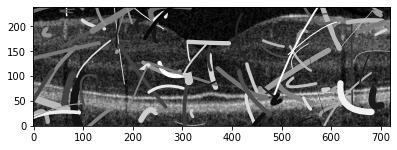

In [104]:
W_L = 2
W_R = 4
W_DR = 1
W_E = 1.2

solution = Worms(100)
print(solution.get_fitness())

drawing = Drawing(image)
drawing.add_worms(solution.get_worms())
drawing.show()


In [44]:
# A population of solutions which consist of N worms.
class ClewsPopulation:
    def __init__(self, population_size, worms_size):
        self.population_size = population_size
        self.clews = [Worms(worms_size) for _ in range(population_size)]

    def get_fittest(self):
        fittest = self.clews[0]

        for worms in self.clews[1:]:
            if worms.get_fitness() > fittest.get_fitness():
                fittest = worms
        return fittest
    
    # Get top n fittest clews
    def get_fittest_elitism(self, n):
        self.clews.sort(key = lambda x: x.get_fitness(), reverse=True)
        return self.clews[:n]
    
    def get_size(self):
        return self.population_size
    
    def get_worms_set(self, index):
        return self.clews[index]
    
    def save_worms_set(self, index, worms: Worms):
        self.clews[index] = worms

In [45]:
class GeneticWormEvolve:
    def __init__(self, population_size, worms_size, mutation_rate=0.05, cross_rate=0.5):
        self.population = ClewsPopulation(population_size, worms_size)
        self.population_size = population_size
        self.worms_size = worms_size
        # self.init_params = init_params

        self.mutation_rate = mutation_rate
        self.cross_rate = cross_rate

    def evolve_by_generation(self, n_generations):
        for count in range(n_generations):
            print("Generation %d: Fittest: %.4f" %(count, self.population.get_fittest().get_fitness()))
            self.population = self.evolve()

        print("Final generation: Fittest: %f" % self.population.get_fittest().get_fitness())

    def evolve(self):
        new_population = ClewsPopulation(self.population_size, self.worms_size)
    
        # Elitism
        new_population.clews.extend(self.population.get_fittest_elitism(int(self.population_size / 2)))

        # Crossover
        for index in range(new_population.get_size()):
            parent1 = self.random_selection()
            parent2 = self.random_selection()
            new_population.save_worms_set(index, self.crossover(parent1, parent2))

        # Mutation
        # self.mutate(clew)

        return new_population

    def random_selection(self):
        random_population = ClewsPopulation(10, self.worms_size)

        for i in range(random_population.get_size()):
            random_index = np.random.randint(self.population.get_size())
            random_population.save_worms_set(i, self.population.get_worms_set(random_index))

        return random_population.get_fittest()
    
    def crossover(self, parent1 : Worms, parent2 : Worms):
        cross_worm = Worms(self.worms_size)
        for i in range(self.worms_size):
            if np.random.rand() < self.cross_rate:
                cross_worm.worms[i] = parent1.worms[i]
            else:
                cross_worm.worms[i] = parent2.worms[i]
        return cross_worm

    def mutate(self, clew: ClewsPopulation):
        for worms in clew.clews:
            for index in range(self.worms_size):
                if np.random.rand() < self.mutation_rate:
                    worms[index] = self.random_worm()

In [46]:
# genWorm = GeneticWormEvolve(10, 50)
# genWorm.evolve_by_generation(20)